# Program to prepare data & train NNs
---

In [1]:
import pandas as pd
import numpy as np
import sklearn
import os

In [25]:
interval_path = "data/intervals/"
signal_path = "data/d-alpha/"
F_ID = "44184"  # 44172 | 44184 | 44194 | 44350

POINTS_DIM = 1024
NUM_CLASSES = 2

In [ ]:
# interval_df = pd.read_csv(interval_path + f"df/{F_ID}_data.csv")
# interval_df.t *= 1e3
# interval_df.describe()

# if os.path.isfile(interval_path + f"df/{F_ID}_data.csv"):
#     df = pd.read_csv(interval_path + f"df/{F_ID}_data.csv", sep=",")
# else:
#     df = pd.read_csv(signal_path + f"sht{F_ID}.txt", sep=",")  # read_dataFile(interval_path + check_filename + ".txt", check_F_ID)  # "_exportGlobus2.dat"
#     df["ch1_marked"] = 0
#     df["ch1_ai_marked"] = 0

# df.loc[int(interval_df.t[0]): int(interval_df.t[interval_df.shape[0] - 1]), 'ch1_marked'] = interval_df.ch1_marked.to_numpy()
# df.describe()

In [26]:
df = pd.read_csv(interval_path + f"df/{F_ID}_data.csv")  # _full

df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,65970.000000,65970.000000,65970.000000,65970.0
mean,197.454500,0.552893,0.240518,0.0
std,19.044043,0.186984,0.487387,0.0
min,164.470000,0.191710,0.000000,0.0
25%,180.962250,0.401320,0.000000,0.0
50%,197.454500,0.534240,0.000000,0.0
75%,213.946750,0.674820,0.000000,0.0
max,230.439000,1.536200,2.000000,0.0


In [4]:
def normalise_series(data):
    max_point, min_point, median_value = data.max(), data.min(), np.median(data)
    return (data - median_value) / abs(max_point - min_point)

In [27]:
data = []

l_edge = 0
slicing_set = [[df.shape[0], 128]]  # [[df.shape[0], 64]] | [[155000, int(POINTS_DIM * 1.5)], [240000, 128], [df.shape[0], int(POINTS_DIM * 1.5)]]
# step = 100

for r_edge, step in slicing_set:
    while l_edge + POINTS_DIM < r_edge:
        df_slice = df.iloc[l_edge:l_edge + POINTS_DIM]
        data.append([normalise_series(df_slice.ch1.to_numpy()), df_slice.ch1_marked.to_numpy()])
        l_edge += step
    print(len(data))

if l_edge + POINTS_DIM - slicing_set[-1][1] != slicing_set[-1][0] - 1:
    # print(df.shape[0] - l_edge)
    df_slice = df.iloc[df.shape[0] - POINTS_DIM:]
    data.append([normalise_series(df_slice.ch1.to_numpy()), df_slice.ch1_marked.to_numpy()])

data_array = np.array(data)

data_array.shape

508


(509, 2, 1024)

In [24]:
# X_train, X_test, y_train, y_test = train_test_split(data_array[:, 0], data_array[:, 1], test_size=0.1, random_state=42)
# np.random.seed(42)
# np.random.shuffle(data_array)
X_train, y_train = data_array[:, 0], data_array[:, 1]
# print(X_train[:10], y_train[:10])

In [28]:
X_train = np.concatenate((X_train, data_array[:, 0]), axis=0)
y_train = np.concatenate((y_train, data_array[:, 1]), axis=0)

In [29]:
X_train.shape

(1097, 1024)

In [ ]:
# !pip install tensorflow

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [30]:
# for multiclass.
y_train = to_categorical(y_train, num_classes=NUM_CLASSES + 1)[:, :, 1:]

In [14]:
# for biclass.
# y_train[y_train != 0] = 1

In [31]:
y_train[:2]

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [16]:
def unet_multi_model(POINTS_DIM, NUM_CLASSES):
    init_relu = tf.keras.initializers.HeUniform()

    #Входной слой
    inputs = tf.keras.layers.Input(shape=(POINTS_DIM, 1,))
    conv_1 = tf.keras.layers.Conv1D(64, 4, 
                                    activation=tf.keras.layers.LeakyReLU(),
                                    strides=2, padding='same', 
                                    kernel_initializer=init_relu,
                                    use_bias=False)(inputs)
    #Сворачиваем
    conv_1_1 = tf.keras.layers.Conv1D(128, 4, 
                                      activation=tf.keras.layers.LeakyReLU(), 
                                      strides=2,
                                      padding='same', 
                                      kernel_initializer=init_relu,
                                      use_bias=False)(conv_1)
    batch_norm_1 = tf.keras.layers.BatchNormalization()(conv_1_1)

    #2
    conv_2 = tf.keras.layers.Conv1D(256, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer=init_relu,
                                    use_bias=False)(batch_norm_1)
    batch_norm_2 = tf.keras.layers.BatchNormalization()(conv_2)

    #3
    conv_3 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer=init_relu,
                                    use_bias=False)(batch_norm_2)
    batch_norm_3 = tf.keras.layers.BatchNormalization()(conv_3)

    #4
    conv_4 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer=init_relu,
                                    use_bias=False)(batch_norm_3)
    batch_norm_4 = tf.keras.layers.BatchNormalization()(conv_4)

    #Разворачиваем
    #1
    up_1 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer=init_relu,
                                                                          use_bias=False)(conv_4), conv_3])
    batch_up_1 = tf.keras.layers.BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = tf.keras.layers.Dropout(0.25)(batch_up_1, training=True)

    #2
    up_2 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer=init_relu,
                                                                          use_bias=False)(batch_up_1), conv_2])
    batch_up_2 = tf.keras.layers.BatchNormalization()(up_2)
    batch_up_2 = tf.keras.layers.Dropout(0.25)(batch_up_2, training=True)


    #3
    up_3 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer=init_relu,
                                                                          use_bias=False)(batch_up_2), conv_1_1])
    batch_up_3 = tf.keras.layers.BatchNormalization()(up_3)
    batch_up_3 = tf.keras.layers.Dropout(0.25)(batch_up_3, training=True)


    #4
    up_4 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer=init_relu,
                                                                          use_bias=False)(batch_up_3), conv_1])
    batch_up_4 = tf.keras.layers.BatchNormalization()(up_4)


    #Выходной слой
    outputs = tf.keras.layers.Conv1DTranspose(NUM_CLASSES, 4, activation='sigmoid', strides=2,
                                                   padding='same',
                                                   kernel_initializer='glorot_normal')(batch_up_4)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [32]:
model = unet_multi_model(POINTS_DIM, NUM_CLASSES)

In [18]:
def focal_loss(y_true, y_pred, alpha=0.1, gamma=2.0):
    bce = K.binary_crossentropy(y_true, y_pred)

    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))

    alpha_factor = y_true * alpha + ((1 - alpha) * (1 - y_true))
    modulating_factor = K.pow((1 - p_t), gamma)

    # compute the final loss and return
    return K.mean(alpha_factor * modulating_factor * bce, axis=-1)

def dice_bce_loss(y_pred, y_true):
    def dice_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)
        
        return 1 - numerator / denominator
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [19]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

@tf.function
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

---
## Learning side
---

In [ ]:
ckpt_v = 1
checkpoint_filepath = f'models/ckpt/checkpoint_{ckpt_v}_multi.weights.h5'
model.compile(optimizer='adam', loss=dice_bce_loss,
                  metrics=['acc', precision, recall, f1_score])
model.load_weights(checkpoint_filepath)

In [33]:
NUM_EPOCHS = 80
callbacks_metric1 = 'val_precision'
callbacks_metric2 = 'val_loss'
callbacks_metric3 = 'val_f1_score'
ckpt_v = 1

fname = f"models/ckpt/checkpoint_{ckpt_v}"+"-e{epoch:03d}-l{val_loss:.2f}-p{val_precision:.2f}-r{val_recall:.2f}_multi.weights.h5"  # " + "-e{epoch:03d}-l{val_loss:.2f}-p{val_precision:.2f}-r{val_recall:.2f}

# checkpoint_filepath = f'models/ckpt/checkpoint_{ckpt_v}_multi-{epoch:03d}-{val_loss:.4f}.weights.h5'
callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=fname,
                                                     save_weights_only=True,
                                                     monitor=callbacks_metric2,
                                                     mode='min',
                                                     save_best_only=True, verbose=1),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fname,
                                                     save_weights_only=True,
                                                     monitor=callbacks_metric1,
                                                     mode='max',
                                                     save_best_only=True, verbose=1),
                 tf.keras.callbacks.ModelCheckpoint(filepath=fname,
                                                     save_weights_only=True,
                                                     monitor=callbacks_metric3,
                                                     mode='max',
                                                     save_best_only=True, verbose=1)]

# , tf.keras.callbacks.EarlyStopping(monitor=callbacks_metric, patience=35)

In [36]:
model.compile(optimizer='adam', loss=dice_bce_loss, metrics=['acc', precision, recall, f1_score])  # remove to train from ckpt
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS,callbacks=callbacks_list, validation_split=0.2, batch_size=64)

Epoch 1/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - acc: 0.3416 - f1_score: 0.6171 - loss: 0.4624 - precision: 0.7427 - recall: 0.5217
Epoch 1: val_loss improved from 0.55087 to 0.48326, saving model to models/ckpt/checkpoint_1-e001-l0.48-p0.72-r0.00_multi.weights.h5

Epoch 1: val_precision improved from 0.48764 to 0.72067, saving model to models/ckpt/checkpoint_1-e001-l0.48-p0.72-r0.00_multi.weights.h5

Epoch 1: val_f1_score did not improve from 0.33481
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 641ms/step - acc: 0.3438 - f1_score: 0.6168 - loss: 0.4613 - precision: 0.7436 - recall: 0.5212 - val_acc: 0.5489 - val_f1_score: 0.0099 - val_loss: 0.4833 - val_precision: 0.7207 - val_recall: 0.0047
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - acc: 0.5006 - f1_score: 0.6144 - loss: 0.4134 - precision: 0.7950 - recall: 0.5076
Epoch 2: val_loss did not improve from 0.48326

Epoch 2: val_precision did not improve from 0.72067

Epoch 2: val_f1_score improved from 0.33481 to 0.38337, saving model 

---
## History checking
---

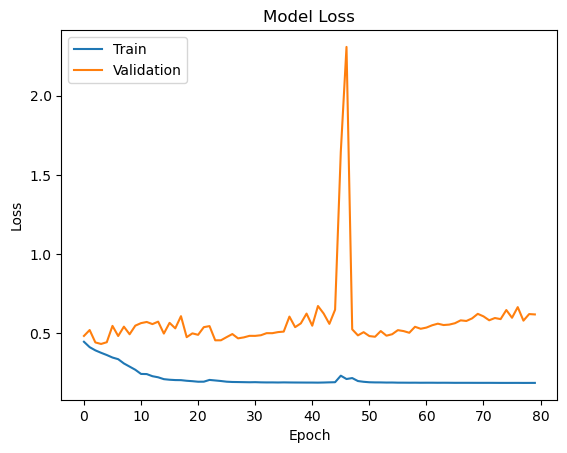

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

---
## Saving NN side
---

In [30]:
neu_version = 1
model.save(f"models/unet_v{neu_version}.keras")

In [20]:
def unet_model(POINTS_DIM):

    #Входной слой
    inputs = tf.keras.layers.Input(shape=(POINTS_DIM, 1,))
    conv_1 = tf.keras.layers.Conv1D(64, 4, 
                                    activation=tf.keras.layers.LeakyReLU(),
                                    strides=2, padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(inputs)
    #Сворачиваем
    conv_1_1 = tf.keras.layers.Conv1D(128, 4, 
                                      activation=tf.keras.layers.LeakyReLU(), 
                                      strides=2,
                                      padding='same', 
                                      kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = tf.keras.layers.BatchNormalization()(conv_1_1)

    #2
    conv_2 = tf.keras.layers.Conv1D(256, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_1)
    batch_norm_2 = tf.keras.layers.BatchNormalization()(conv_2)

    #3
    conv_3 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_2)
    batch_norm_3 = tf.keras.layers.BatchNormalization()(conv_3)

    #4
    conv_4 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_3)
    batch_norm_4 = tf.keras.layers.BatchNormalization()(conv_4)

    #Разворачиваем
    #1
    up_1 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_4), conv_3])
    batch_up_1 = tf.keras.layers.BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = tf.keras.layers.Dropout(0.25)(batch_up_1, training=True)

    #2
    up_2 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_2])
    batch_up_2 = tf.keras.layers.BatchNormalization()(up_2)
    batch_up_2 = tf.keras.layers.Dropout(0.25)(batch_up_2, training=True)


    #3
    up_3 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_1_1])
    batch_up_3 = tf.keras.layers.BatchNormalization()(up_3)
    batch_up_3 = tf.keras.layers.Dropout(0.25)(batch_up_3, training=True)


    #4
    up_4 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_1])
    batch_up_4 = tf.keras.layers.BatchNormalization()(up_4)


    #Выходной слой
    max_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(batch_up_4)
    flat = tf.keras.layers.Flatten()(max_pool)
    flat = tf.keras.layers.Dropout(0.2)(flat, training=True)
    outputs = tf.keras.layers.Dense(POINTS_DIM, activation="sigmoid")(flat)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model